# Statistical modeling and Inference (first problemset from slides)
# José Fernando Moreno Gutiérrez

## Slides 1
#### Exercise 4
The code and graphics for this exercise are also available on Github:
* Code: https://github.com/chpmoreno/BGSE-DS-SMIPS/blob/master/lectures/1/R
* Graphics: https://github.com/chpmoreno/BGSE-DS-SMIPS/tree/master/lectures/1/Graphics

The folder R contains the file [MLE.R](https://github.com/chpmoreno/BGSE-DS-SMIPS/blob/master/lectures/1/R/mle.R) which contains three functions:

* mle_estimator_lm: the function produce the loglikelihood for a linear regression model asumming gaussian errors.
* mle_result: the function store and produce the principal results of the linear model that are used to produce the graphics.
* mle_plots: produce the three plots required for the excercise using gglot2.

Also contains the file [execution.R](https://github.com/chpmoreno/BGSE-DS-SMIPS/blob/master/lectures/1/R/execution.R) which uses the [MLE.R](https://github.com/chpmoreno/BGSE-DS-SMIPS/blob/master/lectures/1/R/mle.R) which contains three functions for produce the graphics.

The following is basically the same programs with little changes for executing it on the present notebook.

**Functions**

In [1]:
mle_estimator_lm <- function (w, t_vector, phi) {
    if(is.vector(t_vector) == FALSE)
      t_vector <- as.vector(t_vector)
    if(is.matrix(phi) == FALSE)
      phi <- as.matrix(phi)
    M <- ncol(phi) 
    phi_w <- phi %*% w[1:M]
    Sig <- w[(M + 1):(M + 1)]
    sum(-(1 / 2) * log(2 * pi) - (1 / 2) * log(Sig ^ 2) - (1 / (2 * Sig ^ 2)) * (t_vector - phi_w) ^ 2)
}

mle_result <- function (mle_estimation_result, t_vector, phi) {
  phi        <- as.matrix(phi) 
  w          <- as.matrix(mle_estimation_result$par[-length(mle_estimation_result$par)])
  sigma      <- last(mle_estimation_result$par)
  variance   <- -solve(mle_estimation_result$hessian)
  w_se       <- sqrt(diag(variance))[1:length(w)]
  sigma_se   <- last(sqrt(diag(variance)))
  z_value    <- w/w_se
  p_value    <- 2 * (1 - pnorm(abs(z_value)))
  t_hat      <- phi %*% w 
  e          <- t_vector - t_hat
  e_st       <- e/sigma_se
  leverage   <- NULL 
  for(i in 1:nrow(phi)){
    leverage <- c(leverage, t(phi[i,]) %*% solve(t(phi) %*% phi) %*% phi[i,])
  }
  # leverage is equivalent to diag(phi %*% solve(t(phi) %*% phi) %*% t(phi))
  # diagonal of the hat matrix
  return(list(w = w, sigma = sigma, variance = variance, w_se = w_se, sigma_se = sigma_se,
              z_value = z_value, p_value = p_value, t_hat = t_hat, e = e, e_st = e_st,
              leverage = leverage, n = nrow(phi)))
}

mle_plots <- function(mle_results){
  ci_plot_data <- data.frame(coeff_number = seq(1:nrow(mle_results$w))) %>% 
                  bind_cols(data.frame(w = mle_results$w)) %>% 
                  mutate(lower_bound = w - 1.96 * mle_results$w_se) %>% 
                  mutate(upper_bound = w + 1.96 * mle_results$w_se) %>% 
                  mutate(color_ci = ifelse(mle_results$p_value < 0.05, "green", "red"))
  
  ci_plot <- ggplot(data = ci_plot_data, aes(x = as.factor(coeff_number), y = w)) + 
             geom_errorbar(aes(ymin = lower_bound, ymax = upper_bound), 
                           color = ci_plot_data$color_ci, width = 0.3) + 
             geom_point() + ggtitle("w estimation and confidence intervals") +
             labs(x = "Coefficient", y = "w, w +/- 1.96 s.e.") + theme_economist()
  
  st_res_plot_data <- data.frame(e_st = mle_results$e_st) %>% 
                      bind_cols(data.frame(t_hat = mle_results$t_hat)) %>% 
                      mutate(leverage_colour = ifelse(mle_results$leverage > 
                                                      (3 * (length(mle_results$w)) / mle_results$n ),
                                                      "red", "black"))
                       
  st_res_plot <- ggplot(data = st_res_plot_data, aes(x = t_hat, y = e_st)) + 
                 geom_point(color = st_res_plot_data$leverage_colour) + 
                 ggtitle("Standard error vs fitted") +
                 labs(x = "fitted values", y = "Standard error") + theme_economist()
  
  qq_plot_data <- qq(mle_results$e)
  
  qq_plot <- ggplot(qq_plot_data$qq_df, aes(x=z, y=ord.x)) +
    geom_abline(intercept = qq_plot_data$qq_coef[1], slope = qq_plot_data$qq_coef[2], color = "red") +
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha=0.2, color = "cadetblue3", fill = "cadetblue2") +
    geom_point() +
    ggtitle("Q-Q plot") +
    labs(x = "Theoretical quantiles", y = "Standarized residuals") + theme_economist()
  
  return(list(ci_plot = ci_plot, st_res_plot = st_res_plot, qq_plot = qq_plot))
}

qq <- function(x, distribution = "norm", ..., line.estimate = NULL, conf = 0.95,
                  labels = names(x)){
  q.function <- eval(parse(text = paste0("q", distribution)))
  d.function <- eval(parse(text = paste0("d", distribution)))
  x <- na.omit(x)
  ord <- order(x)
  n <- length(x)
  P <- ppoints(length(x))
  df <- data.frame(ord.x = x[ord], z = q.function(P, ...))
  
  if(is.null(line.estimate)){
    Q.x <- quantile(df$ord.x, c(0.25, 0.75))
    Q.z <- q.function(c(0.25, 0.75), ...)
    b <- diff(Q.x)/diff(Q.z)
    coef <- c(Q.x[1] - b * Q.z[1], b)
  } else {
    coef <- coef(line.estimate(ord.x ~ z))
  }
  
  zz <- qnorm(1 - (1 - conf)/2)
  SE <- (coef[2]/d.function(df$z)) * sqrt(P * (1 - P)/n)
  fit.value <- coef[1] + coef[2] * df$z
  df$upper <- fit.value + zz * SE
  df$lower <- fit.value - zz * SE
  
  if(!is.null(labels)){ 
    df$label <- ifelse(df$ord.x > df$upper | df$ord.x < df$lower, labels[ord],"")
  }
  
  return(list(qq_df = df, qq_coef = coef))
}

**Code for creating the graphics**

In [ ]:
# load libraries and functions needed
library(dplyr)
library(ggplot2)
library(ggthemes)
library(grid)
library(gridExtra)
source("1/R/mle.R")

# initial parameters ####
m <- 30 # number of variables taken for the model

# load data - Find it on https://1drv.ms/t/s!Ai0XbELt7PXquFJtWenDbxvksoXM ####
working_directory  <- "/home/chpmoreno/Documents/OneDrive/Documents/BGSE/First_Term/SMI/Datasets/synthetic_regression/synthetic_regression.txt"
data_exercise <- read.table(file = working_directory,
                                  nrow = 300)[,1:(m + 1)]

# vector t (t_vector) and matrix phi
t_vector <- as.vector(data_exercise[ , "t"])
phi      <- cbind(rep(1, length(t_vector)), 
                  data_exercise[,-which(names(data_exercise) %in% c("t"))])
colnames(phi)[1] <- "const"

# mle_estimation
mle_estimation_result <- optim(runif(m + 2, 0, 1), mle_estimator_lm, phi = phi, 
                               t_vector = t_vector, method = "BFGS", 
                               control = list(trace = 1, maxit = 10000, fnscale = -1),
                               hessian = TRUE)

# mle_results
mle_results <- mle_result(mle_estimation_result, t_vector, phi)

# mle graphics
mle_graphics <- mle_plots(mle_results)

**printing the graphics**

*Graphic 1*

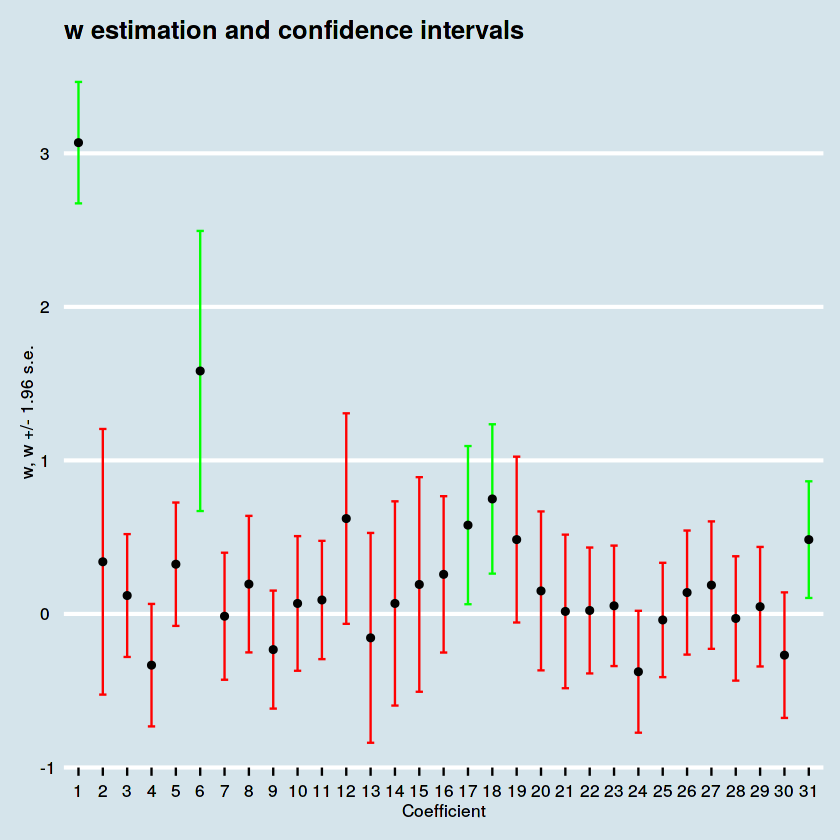

In [7]:
print(mle_graphics$ci_plot)

*Graphic 2*

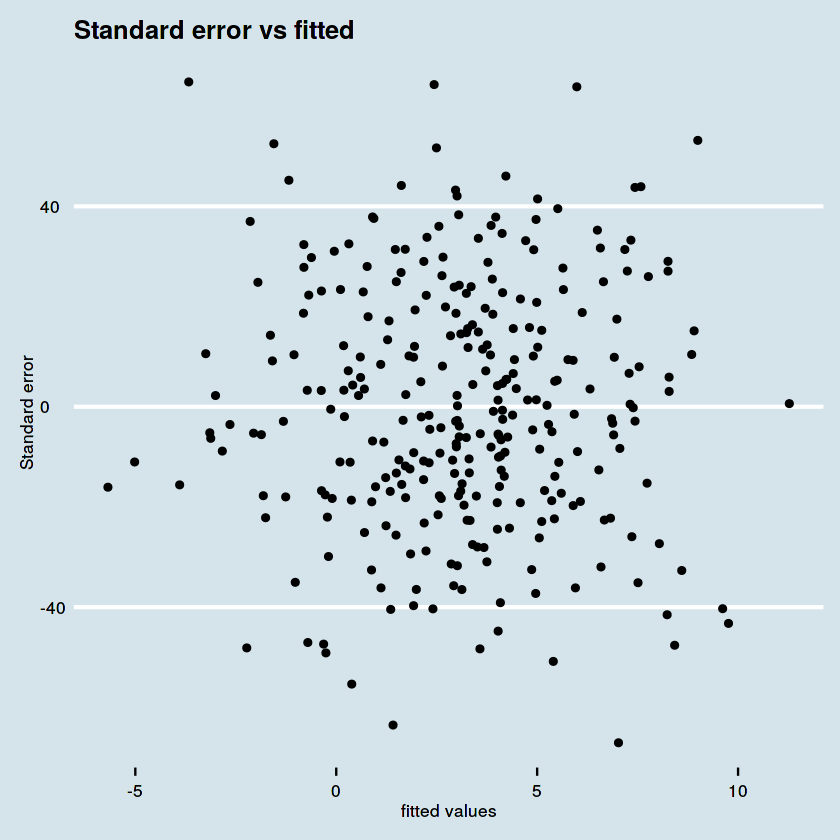

In [8]:
print(mle_graphics$st_res_plot)

*Graphic 3*

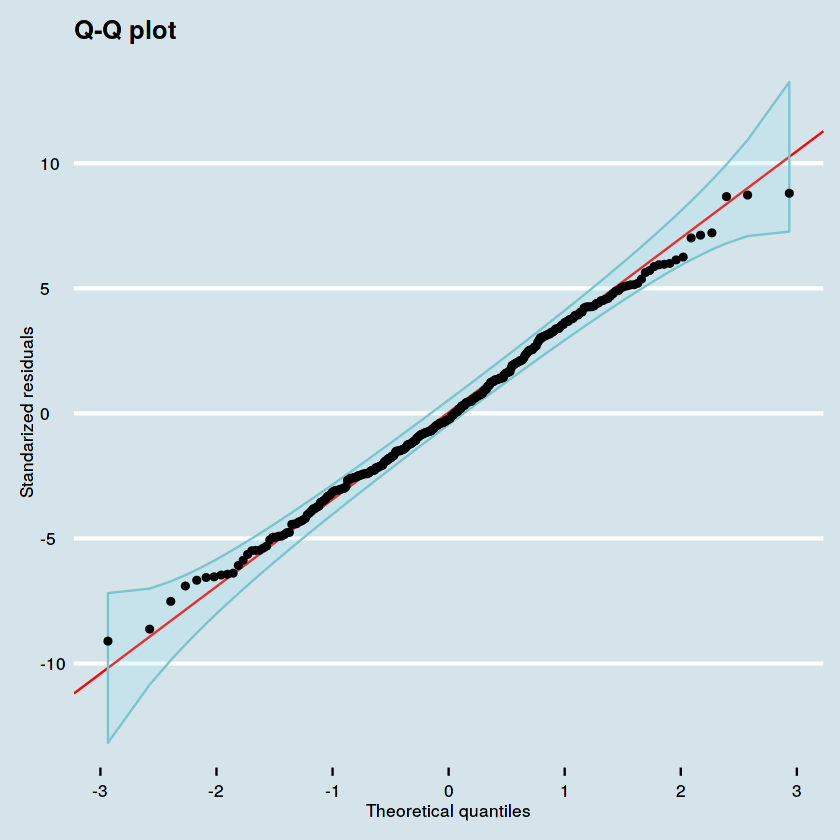

In [9]:
print(mle_graphics$qq_plot)

## Slides 2
#### Exercise 2
The code and graphics for this exercise are also available on Github:
* Code: https://github.com/chpmoreno/BGSE-DS-SMIPS/blob/master/lectures/1/R
* Graphics: https://github.com/chpmoreno/BGSE-DS-SMIPS/tree/master/lectures/1/Graphics

The folder R contains the file [MLE.R](https://github.com/chpmoreno/BGSE-DS-SMIPS/blob/master/lectures/1/R/mle.R) which contains three functions:

* mle_estimator_lm: the function produce the loglikelihood for a linear regression model asumming gaussian errors.
* mle_result: the function store and produce the principal results of the linear model that are used to produce the graphics.
* mle_plots: produce the three plots required for the excercise using gglot2.

Also contains the file [execution.R](https://github.com/chpmoreno/BGSE-DS-SMIPS/blob/master/lectures/1/R/execution.R) which uses the [MLE.R](https://github.com/chpmoreno/BGSE-DS-SMIPS/blob/master/lectures/1/R/mle.R) which contains three functions for produce the graphics.

The following is basically the same programs with little changes for executing it on the present notebook.